In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision,Recall,Accuracy,F1Score
from keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import plot_model
from IPython.display import Image


In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

validat_datagen = ImageDataGenerator(
        rescale = 1./255
        )

test_datagen = ImageDataGenerator(
        rescale = 1./255
        )


In [37]:
classes = ['adenocarcinoma','large.cell.carcinoma','normal','squamous.cell.carcinoma']

In [39]:
train_dataset = train_datagen.flow_from_directory(directory='/kaggle/input/chest-ctscan-images/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64,
                                                 )

validat_dataset = validat_datagen.flow_from_directory(directory='/kaggle/input/chest-ctscan-images/Data/valid',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64,
                                            
                                    )

test_data_set = test_datagen.flow_from_directory(directory='/kaggle/input/chest-ctscan-images/Data/test',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64,
                                                )

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


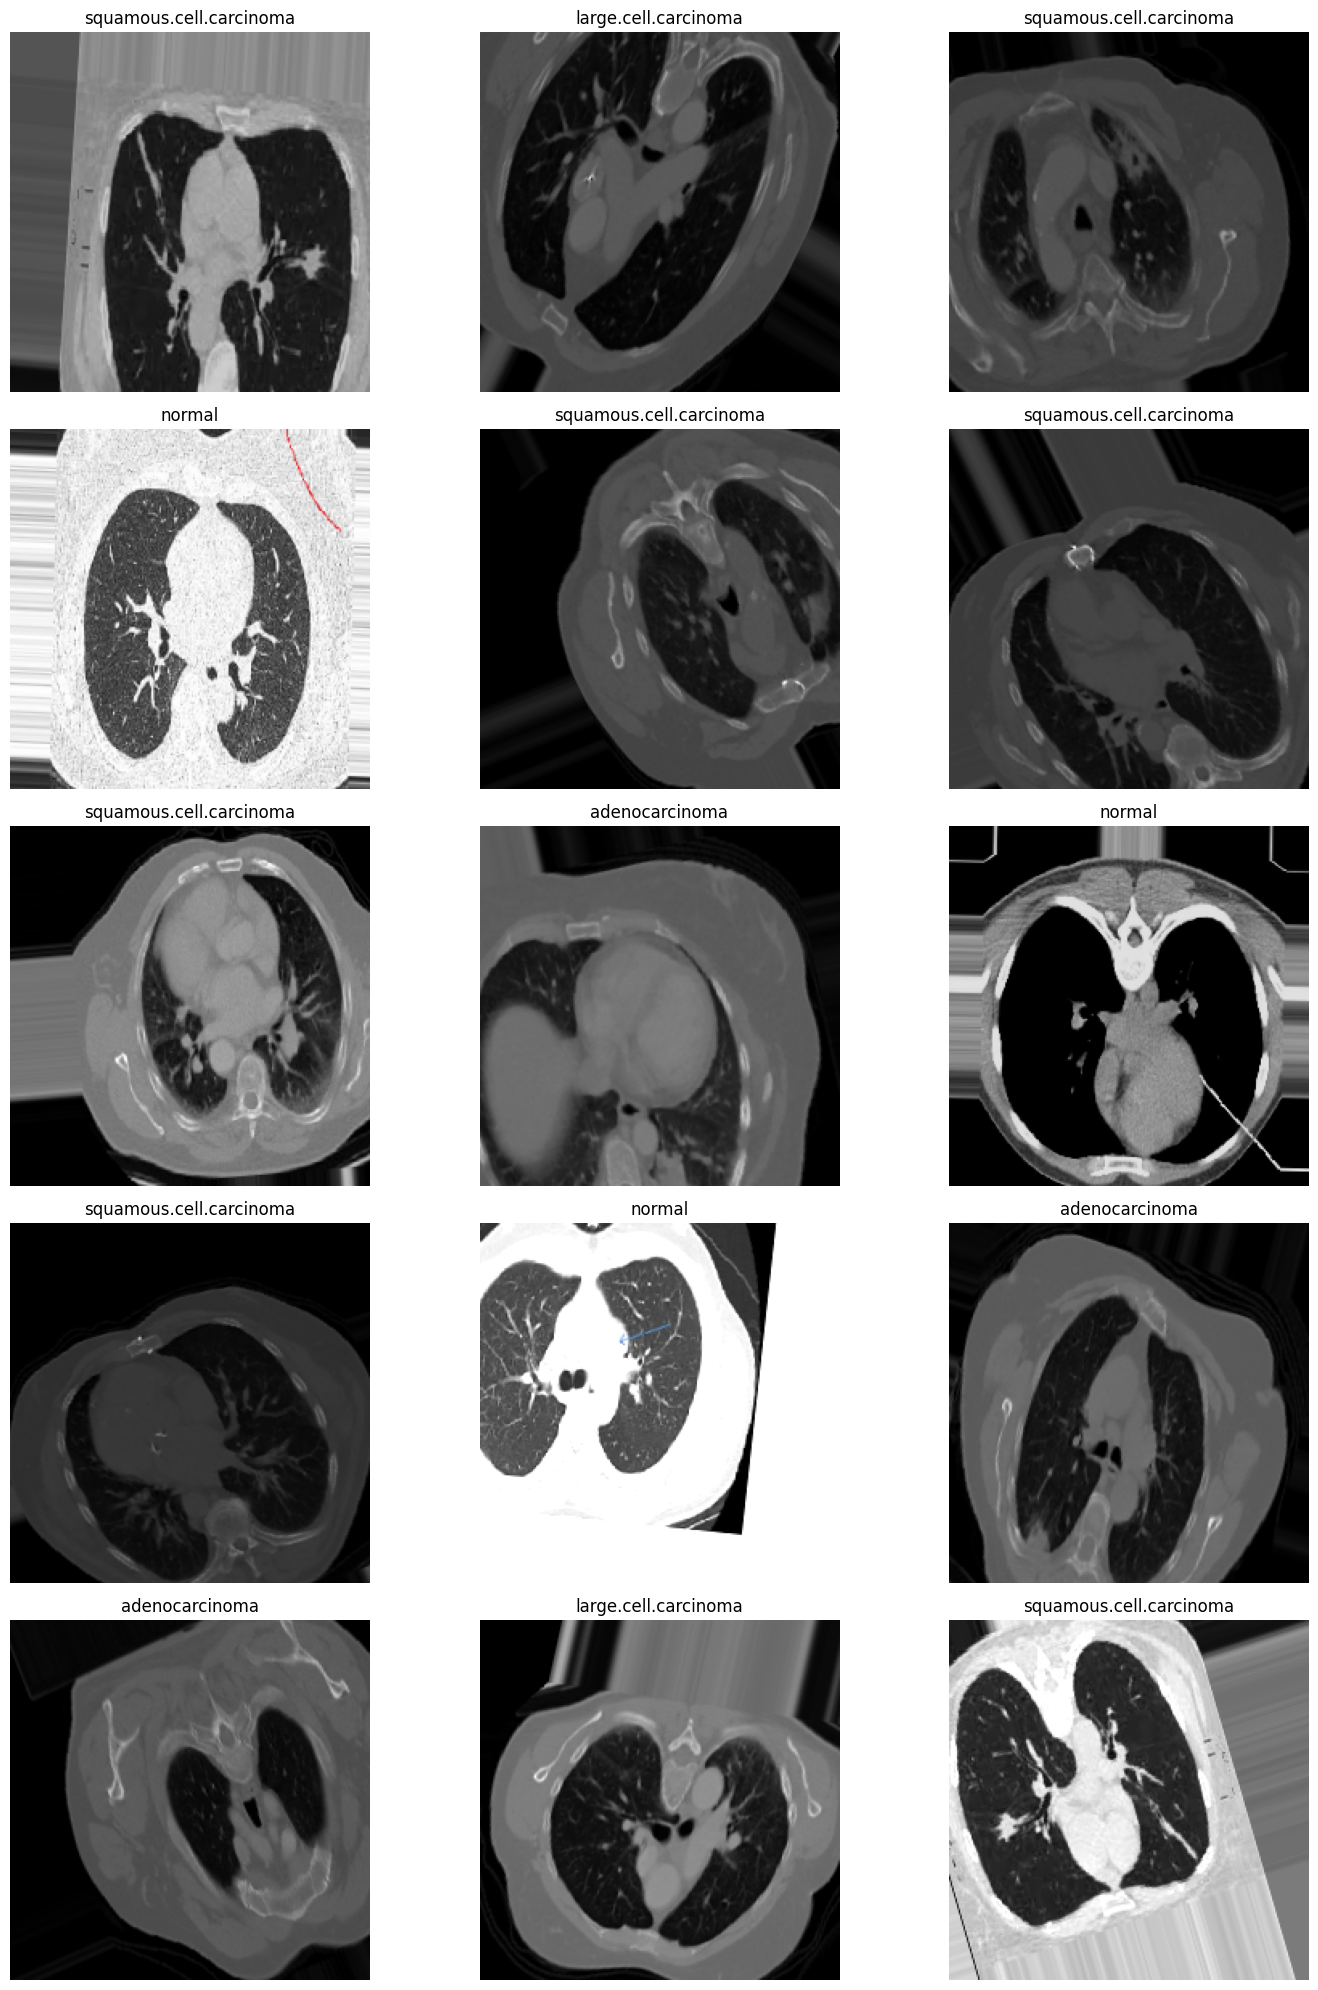

In [17]:
# plot images from train datasets
train_images,train_labels = next(train_dataset)

# plot 20 image from train dataset with thier labels
plt.figure(figsize=(15,20))
for i in range(15):
  plt.subplot(5,3,i+1)
  plt.imshow(train_images[i])
  plt.title(labels[np.argmax(train_labels[i])])
  plt.axis('off')
plt.tight_layout()
plt.show()


## Building VGG16 from scratch

In [46]:
def Bulid_VGG16(input_shape=(224,224,3),num_class=4):
  model = Sequential()
  # block 1
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',input_shape=input_shape))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
  # block 2

  model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())

  # block 3
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())
    
  # block 4
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(BatchNormalization())

  model.add(Flatten())

  # block 5
  model.add(Dense(units=64,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(units=num_class,activation='softmax'))

  return model



In [47]:
model = Bulid_VGG16()

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,471,876 (51.39 MB)

 Trainable params: 13,469,956 (51.38 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [49]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['Accuracy'])

In [54]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_data_set, epochs=53, verbose=2)

Epoch 1/53
10/10 - 19s - 2s/step - Accuracy: 0.6069 - loss: 0.8249 - val_Accuracy: 0.3460 - val_loss: 1.9189
Epoch 2/53
10/10 - 18s - 2s/step - Accuracy: 0.6346 - loss: 0.8163 - val_Accuracy: 0.3524 - val_loss: 1.2934
Epoch 3/53
10/10 - 18s - 2s/step - Accuracy: 0.6036 - loss: 0.8613 - val_Accuracy: 0.3048 - val_loss: 2.2639
Epoch 4/53
10/10 - 18s - 2s/step - Accuracy: 0.6085 - loss: 0.8230 - val_Accuracy: 0.4603 - val_loss: 1.0182
Epoch 5/53
10/10 - 18s - 2s/step - Accuracy: 0.6330 - loss: 0.7883 - val_Accuracy: 0.5492 - val_loss: 0.9513
Epoch 6/53
10/10 - 18s - 2s/step - Accuracy: 0.6297 - loss: 0.8104 - val_Accuracy: 0.5873 - val_loss: 0.8511
Epoch 7/53
10/10 - 18s - 2s/step - Accuracy: 0.6427 - loss: 0.7821 - val_Accuracy: 0.5238 - val_loss: 0.8864
Epoch 8/53
10/10 - 18s - 2s/step - Accuracy: 0.6069 - loss: 0.8207 - val_Accuracy: 0.5651 - val_loss: 0.9404
Epoch 9/53
10/10 - 18s - 2s/step - Accuracy: 0.6346 - loss: 0.7808 - val_Accuracy: 0.6000 - val_loss: 1.0393
Epoch 10/53
10/10 -

Text(0, 0.5, 'accuracy')

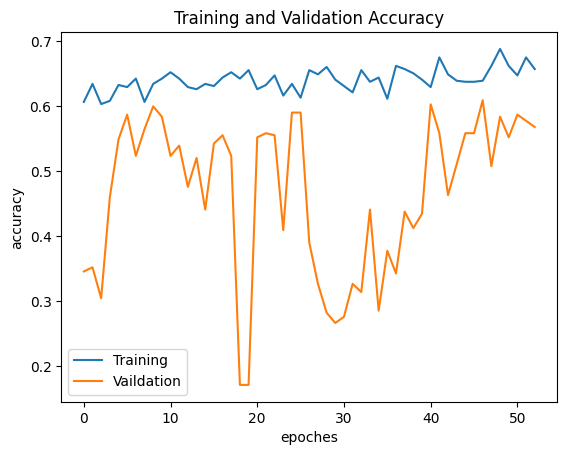

In [57]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.ylabel('accuracy')

In [58]:
y_pred= model.predict(test_data_set)
import numpy as np
y_pred1=np.argmax(y_pred,axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 439ms/step


In [59]:
from sklearn.metrics import classification_report
report=classification_report(test_data_set.labels,y_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.38      0.61      0.47       120
           1       0.22      0.29      0.25        51
           2       0.22      0.22      0.22        54
           3       0.00      0.00      0.00        90

    accuracy                           0.32       315
   macro avg       0.21      0.28      0.24       315
weighted avg       0.22      0.32      0.26       315



In [60]:
x_test,y_test = next(test_data_set)
loss, accuracy = model.evaluate(x_test, y_test, batch_size=None, verbose=1, sample_weight=None)


2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - Accuracy: 0.5938 - loss: 0.9556
